In [1]:
import numpy as np
import pandas as pd
import math
import datetime
import warnings
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MinuteLocator
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

In [2]:
# Read the data
data = pd.read_csv('UnderlyingOptionsIntervalsCalcs_60sec_2018-02-21.csv')
data['quote_datetime'] = data['quote_datetime'].apply(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
data['expiration'] = data['expiration'].apply(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d'))
quote_time_list = data['quote_datetime'].unique()
data

,underlying_symbol,quote_datetime,root,expiration,strike,option_type,open,high,low,close,trade_volume,bid_size,bid,ask_size,ask,underlying_bid,underlying_ask,implied_underlying_price,active_underlying_price,implied_volatility,delta,gamma,theta,vega,rho
0,^SPX,2018-02-21 09:31:00,SPXW,2018-02-21,1700.0,C,0.0,0.0,0.0,0.0,0,2,1010.7,1,1027.8,2716.80,2722.50,2718.8196,2719.2900,6.1853,0.9973,0.0000,-0.4114,0.0065,1.3489
1,^SPX,2018-02-21 09:32:00,SPXW,2018-02-21,1700.0,C,0.0,0.0,0.0,0.0,0,1,1010.5,1,1027.2,2718.56,2723.10,2720.3197,2720.7100,0.0200,1.0000,0.0000,0.0000,0.0000,1.3520
2,^SPX,2018-02-21 09:33:00,SPXW,2018-02-21,1700.0,C,0.0,0.0,0.0,0.0,0,1,1012.8,1,1027.8,2721.96,2725.59,2723.3697,2723.7000,0.0200,1.0000,0.0000,0.0000,0.0000,1.3487
3,^SPX,2018-02-21 09:34:00,SPXW,2018-02-21,1700.0,C,0.0,0.0,0.0,0.0,0,1,1014.1,1,1027.8,2722.81,2725.95,2724.1198,2724.4800,0.0200,1.0000,0.0000,0.0000,0.0000,1.3455
4,^SPX,2018-02-21 09:35:00,SPXW,2018-02-21,1700.0,C,0.0,0.0,0.0,0.0,0,1,1014.7,1,1027.8,2722.77,2725.66,2724.1199,2724.1899,0.0200,1.0000,0.0000,0.0000,0.0000,1.3423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5090035,^VIX,2018-02-21 16:11:00,VIX,2018-08-22,70.0,P,0.0,0.0,0.0,0.0,0,348,51.6,744,52.1,20.15,20.15,17.7331,20.1500,0.9950,-0.9443,0.0090,-0.0003,0.0141,-34.1510
5090036,^VIX,2018-02-21 16:12:00,VIX,2018-08-22,70.0,P,0.0,0.0,0.0,0.0,0,369,51.6,744,52.1,20.23,20.23,17.7331,20.2300,0.9950,-0.9443,0.0090,-0.0003,0.0141,-34.1509
5090037,^VIX,2018-02-21 16:13:00,VIX,2018-08-22,70.0,P,0.0,0.0,0.0,0.0,0,360,51.6,480,52.0,20.17,20.17,17.7331,20.1700,0.9567,-0.9538,0.0081,0.0000,0.0121,-34.2099
5090038,^VIX,2018-02-21 16:14:00,VIX,2018-08-22,70.0,P,0.0,0.0,0.0,0.0,0,301,51.7,401,52.1,20.04,20.04,17.6831,20.0400,0.9970,-0.9442,0.0090,-0.0003,0.0140,-34.1515


In [3]:
def get_option_dates(quote_date, unique_dates):
    """
    Find the near_term and next_term expiration dates.
    
    Keyword arguments:
    quote_date -- the date of VIX to be replicated
    unique_dates -- a set of all unique expiration dates from the data
    
    Example:
    get_option_dates(datetime.datetime(2018, 2, 21), set(data['expiration'])) retrun the two expiration dates with
    2018/2/21 as the options quote date
    """
    # A dictionary which maps the weekday(0:Monday, 1:Tuesday, ..., 6:Sunday) to the two numbers of remaining days 
    # that would be used to compute the near_term and next_term expiration dates
    weekday_date_dict = {0:(25,32), 1:(24,31), 2:(30,37), 3:(29,36), 4:(28,35), 5:(27,34), 6:(26,33)}
    weekday = quote_date.weekday()
    dates = []
    for day in weekday_date_dict[weekday]:
        expire_date = quote_date + datetime.timedelta(days=day)
        # if the expiration date(Friday) is an exchange holiday, select options that expire one day before(Thursday)
        if expire_date not in unique_dates:
            expire_date -= datetime.timedelta(days=1)
        dates.append(expire_date)
    return dates

def get_strike_price(options_df):
    """
    Find the strike price at which the absolute difference between the call and put prices is smallest. 
    This strike price would be used in the calculation of F, the forward index price. Return the strike price and
    a pivoted dataframe which would be helpful in the later calculation.
    
    Keyword arguments:
    options_df -- the dataframe with either all the near_term or all the next_term options
    
    Example:
    get_strike_price(near_term) returns the strike price for the near-term options and a pivoted dataframe
    """
    # Create a pivoted dataframe with strike price as the index, call and put option price as columns
    pivoted_df = options_df[['strike', 'option_type', 'Average Price']].pivot(index='strike', columns='option_type', values='Average Price')
    # Calculate the absolute difference between the prices of call and put options with the same strike price
    pivoted_df['Difference'] = abs(pivoted_df['C']-pivoted_df['P'])
    strike_price = pivoted_df[pivoted_df.Difference == pivoted_df.Difference.min()].index[0]
    return strike_price, pivoted_df

def get_T(curr_hour, curr_min, curr_date, expire_date, option_root):
    """
    Find T, the time to expiration, in year by adding up the minutes remaining until midnight of the current day, 
    the minutes from midnight until 9:30 a.m. ET for 'standard' SPX expirations or minutes from midnight until
    4:00 p.m. ET for 'weekly' SPX expirations, and the total minutes in the days between current day and expiration day.
    
    Keyword arguments:
    curr_hour -- the current hour in 24-hour clock(e.g. 16)
    curr_min -- the current minute(e.g. 15)
    curr_date -- the current date(the quote date) in datetime format
    expire_date -- the expiration date of the options(the expiration date of near_term or next_term) in datetime format
    option_root -- the option root string(Standard or Weekly) from the 'root' column of the data, 'SPX' represents 
                    'standard' options while 'SPXW' represents 'weekly' options
                    
    Example:
    get_T(16, 15, datetime.datetime(2018, 2, 21), expire_dates[0], near_term.root.iloc[0]) returns the T for near-term
    options given 2018/2/21 16:15 as the current date and time
    """
    M_current_day = 24*60-(curr_hour*60+curr_min)
    M_settlement_day = 60*9.5 if option_root == 'SPX' else 60*16
    M_other_days = ((expire_date-curr_date).days-1)*1440
    return (M_current_day+M_settlement_day+M_other_days)/525600

def get_F(strike_price, R, T, pivoted_df):
    """
    Find F, the forward index price.
    
    Keyword arguments:
    strike_price -- the strike price obtained from get_strike_price()
    R -- the risk-free interest rate for the corresponding term
    T -- the time to expiration obtained from get_T() for the corresponding term
    pivoted_df -- the pivoted dataframe of either near_term or next_term options obtained from get_strike_price()
    
    Example:
    get_F(near_term_strike, R1, T1, pivoted_near_term) returns the F value for near term options
    """
    F = strike_price + math.exp(R*T)*(pivoted_df.loc[strike_price]['C']-pivoted_df.loc[strike_price]['P'])
    return F

def get_K0(options_df, F):
    """
    Find K0, the strike price equal to or otherwise immediately below F, the forward index level.
    
    Keyword arguments:
    options_df -- the dataframe with either all the near_term or all the next_term options
    F -- the forward index price obtained from get_F() for the corresponding term
    
    Example:
    get_K0(near_term, F1) returns the K0 value for near-term options
    """
    K0 = [i for i in options_df['strike'].unique() if i <= F][-1]
    return K0

def put_option_selection(options_df, K0):
    """
    Select out-of-the-money put options with strike prices < K0.
    
    Keyword arguments:
    options_df -- the dataframe with either all the near_term or all the next_term options
    K0 -- the K0 obtained from get_K0() for the corresponding term
    
    Example:
    put_option_selection(near_term, K1) returns a dataframe with all the selected near-term put options
    """
    put_options_df = options_df[(options_df.option_type == 'P') & (options_df.strike < K0)]
    include_list = []
    stop = False
    # Start with the put strike immediately lower than K0 and move to successively lower strike prices    
    for index, row in put_options_df.iloc[::-1].iterrows():
        if not stop:
            # Include only options with bids and stop when two consecutive options are found to have zero bid prices
            if row['bid'] != 0.0:
                include_list.insert(0, 'Yes')
            else:
                include_list.insert(0, 'No')
                if include_list[0] == include_list[1] == 'No':
                    stop = True
        else:
            include_list.insert(0, 'No')
    # Add a column in the dataframe to indicate whether the option would be included in the future calculations
    put_options_df['Include'] = include_list
    return put_options_df

def call_option_selection(options_df, K0):
    """
    Select out-of-the-money call options with strike prices > K0.
    
    Keyword arguments:
    options_df -- the dataframe with either all the near_term or all the next_term options
    K0 -- the K0 obtained from get_K0() for the corresponding term
    
    Example:
    call_option_selection(near_term, K1) returns a dataframe with all the selected near-term call options
    """
    call_options_df = options_df[(options_df.option_type == 'C') & (options_df.strike > K0)]
    include_list = []
    stop = False
    # Start with the call strike immediately higher than K0 and move to successively higher strike prices     
    for index, row in call_options_df.iterrows():
        if not stop:
            # Include only options with bids and stop when two consecutive options are found to have zero bid prices
            if row['bid'] != 0.0:
                include_list.append('Yes')
            else:
                include_list.append('No')
                if include_list[-1] == include_list[-2] == 'No':
                    stop = True
        else:
            include_list.append('No')
    # Add a column in the dataframe to indicate whether the option would be included in the future calculations
    call_options_df['Include'] = include_list
    return call_options_df

def atm_option_selection(options_df, K0):
    """
    Select at-the-money call and put options with strike prices = K0.
    
    Keyword arguments:
    options_df -- the dataframe with either all the near_term or all the next_term options
    K0 -- the K0 obtained from get_K0() for the corresponding term
    
    Example:
    atm_option_selection(near_term, K1) returns a dataframe with all the selected near-term atm options
    """
    atm_options_df = options_df[options_df.strike == K0]
    # Calculate the price as the average price of the two options and only keep one record for future calculations
    atm_options_df['Average Price'] = [(atm_options_df['bid'] + atm_options_df['ask']).sum()/4]*2
    atm_options_df = atm_options_df[:-1]
    return atm_options_df

def all_option_selection(put_options_df, call_options_df, atm_options_df):
    """
    Combine the three dataframes with selected otm put, otm call, and atm options.
    
    Keyword arguments:
    put_options_df -- the dataframe with all the selected otm put options obtained from put_option_selection()
    call_options_df -- the dataframe with all the selected otm call options obtained from call_option_selection()
    atm_options_df -- the dataframe with the selected atm option obtained from atm_option_selection()
    
    Example:
    all_option_selection(near_term_p, near_term_c, near_term_atm) returns a dataframe with all the selected near-term options
    """
    all_options_df = pd.concat([put_options_df[put_options_df.Include == 'Yes'], call_options_df[call_options_df.Include == 'Yes'], atm_options_df])
    all_options_df = all_options_df[['strike', 'option_type', 'Average Price']]
    all_options_df = all_options_df.sort_values(by=['strike'])
    return all_options_df

def get_volatility(all_options_df, R, T, F, K0):
    """
    Calculate the volatility for either the near-term or the next-term options.
    
    Keyword arguments:
    all_options_df -- the dataframe with all the selected options for the corresponding term obtained from all_option_selection()
    R -- the risk-free interest rate for the corresponding term
    T -- the time to expiration obtained from get_T() for the corresponding term
    F -- the forward index price obtained from get_F() for the corresponding term
    K0 -- the K0 obtained from get_K0() for the corresponding term
    
    Example:
    get_volatility(near_term_all, R1, T1, F1, K1) returns the near-term volatility given all the selected near-term
    options, R, as well as the calculated T, F, and K0
    """
    price_list = list(all_options_df['Average Price'])
    strike_list = list(all_options_df['strike'])
    delta_k_list = []
    # Iterate all the strike price of the selected options and calculate the delta_k, which is half the difference 
    # between the strike prices on either side of that strike price. At the upper and lower edges of any given strip 
    # of options, delta_k would be the difference between thatstrike price and the adjacent strike price
    for i in range(len(strike_list)):
        # Upper edge
        if i == 0:
            delta_k_list.append(strike_list[i+1]-strike_list[i])
        # Lower edge
        elif i == len(strike_list)-1:
            delta_k_list.append(strike_list[i]-strike_list[i-1])
        else:
            delta_k_list.append((strike_list[i+1]-strike_list[i-1])/2)

    contribution_list = []
    # Calculate the contribution of every option
    for i in range(len(delta_k_list)):
        contribution = (delta_k_list[i]/strike_list[i]**2)*np.exp(R*T)*price_list[i]
        contribution_list.append(contribution)

    # Calculate the volatility
    volatility = 2/T*math.fsum(contribution_list) - 1/T*(F/K0-1)**2
    return volatility

def get_VIX(T1, T2, volatility1, volatility2):
    """
    Calculate the VIX index value using the VIX formula.
    
    Keyword arguments:
    T1 -- the time to expiration obtained from get_T() for near_term
    T2 -- the time to expiration obtained from get_T() for next_term
    volatility1 -- the volatility obtained from get_volatility() for near_term
    volatility2 -- the volatility obtained from get_volatility() for next_term
    
    Example:
    get_VIX(T1, T2, volatility1, volatility2) returns the VIX value given the near-term and next-term T, as well as
    near-term and next-term volatility
    """
    # number of minutes to settlement of the near-term options
    N1 = T1*525600
    # number of minutes to settlement of the next-term options
    N2 = T2*525600
    # number of minutes in 30 days
    N30 = 43200
    # number of minutes in a 365-day year
    N365 = 525600
    # Calculate the 30-day weighted average of volatility1 and volatility2, take the square root of that value 
    # and multiply by 100 to get the VIX Index value
    VIX = 100*np.sqrt((T1*volatility1*((N2-N30)/(N2-N1))+T2*volatility2*((N30-N1)/(N2-N1)))*(N365/N30))
    return VIX

In [4]:
# Step 1: Get the near_term and next_term expiration dates, and filter the dataset accordingly 
expire_dates = get_option_dates(datetime.datetime(2018, 2, 21), set(data['expiration']))
data_two_dates = data[data.expiration.isin(expire_dates)]
data_two_dates['Average Price'] = (data_two_dates['bid'] + data_two_dates['ask'])/2
data_two_dates

,underlying_symbol,quote_datetime,root,expiration,strike,option_type,open,high,low,close,trade_volume,bid_size,bid,ask_size,ask,underlying_bid,underlying_ask,implied_underlying_price,active_underlying_price,implied_volatility,delta,gamma,theta,vega,rho,Average Price
2008800,^SPX,2018-02-21 09:31:00,SPXW,2018-03-23,700.0,C,0.0,0.0,0.0,0.0,0,1,2007.3,1,2024.3,2716.80,2722.50,2716.1497,2719.2900,0.0200,1.0000,0.0000,-0.0284,0.0000,58.0207,2015.80
2008801,^SPX,2018-02-21 09:32:00,SPXW,2018-03-23,700.0,C,0.0,0.0,0.0,0.0,0,1,2007.5,1,2024.3,2718.56,2723.10,2717.5998,2720.7100,0.0200,1.0000,0.0000,-0.0284,0.0000,58.0194,2015.90
2008802,^SPX,2018-02-21 09:33:00,SPXW,2018-03-23,700.0,C,0.0,0.0,0.0,0.0,0,2,2009.9,1,2024.3,2721.96,2725.59,2720.6937,2723.7000,0.0200,1.0000,0.0000,-0.0284,0.0000,58.0181,2017.10
2008803,^SPX,2018-02-21 09:34:00,SPXW,2018-03-23,700.0,C,0.0,0.0,0.0,0.0,0,1,2010.4,1,2028.5,2722.81,2725.95,2721.1938,2724.4800,0.0200,1.0000,0.0000,-0.0284,0.0000,58.0167,2019.45
2008804,^SPX,2018-02-21 09:35:00,SPXW,2018-03-23,700.0,C,0.0,0.0,0.0,0.0,0,1,2010.0,1,2028.5,2722.77,2725.66,2720.9939,2724.1899,0.0200,1.0000,0.0000,-0.0284,0.0000,58.0154,2019.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2483455,^SPX,2018-02-21 16:11:00,SPXW,2018-03-29,3400.0,P,0.0,0.0,0.0,0.0,0,125,694.3,125,710.4,2665.24,2730.71,2693.0421,2701.3301,0.2876,-0.9941,0.0001,0.0000,0.1416,-333.4445,702.35
2483456,^SPX,2018-02-21 16:12:00,SPXW,2018-03-29,3400.0,P,0.0,0.0,0.0,0.0,0,125,694.3,125,710.4,2664.99,2730.42,2692.8922,2701.3301,0.2755,-0.9958,0.0001,0.0000,0.1051,-333.8686,702.35
2483457,^SPX,2018-02-21 16:13:00,SPXW,2018-03-29,3400.0,P,0.0,0.0,0.0,0.0,0,1,692.6,1,712.8,2665.19,2729.46,2693.7349,2701.3301,0.3329,-0.9846,0.0001,-0.0127,0.3275,-331.0119,702.70
2483458,^SPX,2018-02-21 16:14:00,SPXW,2018-03-29,3400.0,P,0.0,0.0,0.0,0.0,0,125,694.3,126,710.0,2665.37,2733.48,2694.9349,2701.3301,0.3499,-0.9796,0.0002,-0.0641,0.4163,-329.7424,702.15


In [5]:
# Step 2: Split the dataset according to the quotetime
VIX_list = []

data_first_expire = data_two_dates[data_two_dates.expiration == expire_dates[0]]
data_second_expire = data_two_dates[data_two_dates.expiration == expire_dates[1]]

for quote_time in quote_time_list:
    
    # Step 3: Split the dataset into a near_term dataset and a next_term dataset
    near_term = data_first_expire[data_first_expire.quote_datetime == quote_time]
    next_term = data_second_expire[data_second_expire.quote_datetime == quote_time]
    
    # Step 4: Calculate the strike prices used in the calculation of F for both near_term and next_term options
    near_term_strike, pivoted_near_term = get_strike_price(near_term)
    next_term_strike, pivoted_next_term = get_strike_price(next_term)
    
    # Step 5: Calculate T, time to expiration, for both near_term and next_term options
    quote_time_dt = pd.to_datetime(quote_time)
    T1 = get_T(quote_time_dt.hour, quote_time_dt.minute, datetime.datetime(quote_time_dt.year, 
               quote_time_dt.month, quote_time_dt.day), expire_dates[0], near_term.root.iloc[0])
    T2 = get_T(quote_time_dt.hour, quote_time_dt.minute, datetime.datetime(quote_time_dt.year, 
                quote_time_dt.month, quote_time_dt.day), expire_dates[1], next_term.root.iloc[0])
    
    # Step 6: Calculate F, forward index price, for both near_term and next_term options
    # The R values are the 1-Month Daily Treasury Yield Curve Rates acquired from treasury.gov
    R1 = 0.0139
    R2 = 0.0139
    F1 = get_F(near_term_strike, R1, T1, pivoted_near_term)
    F2 = get_F(next_term_strike, R2, T2, pivoted_next_term)
    
    # Step 7: Calculate K0, the strike price equal to or immediately below F, for both near_term and next_term options
    K1 = get_K0(near_term, F1)
    K2 = get_K0(next_term, F2)

    # Step 8: Select otm put, otm call, and atm options for near_term options 
    near_term_p = put_option_selection(near_term, K1)
    near_term_c = call_option_selection(near_term, K1)
    near_term_atm = atm_option_selection(near_term, K1)
    near_term_all = all_option_selection(near_term_p, near_term_c, near_term_atm)

    # Step 9: Select otm put, otm call, and atm options for next_term options 
    next_term_p = put_option_selection(next_term, K2)
    next_term_c = call_option_selection(next_term, K2)
    next_term_atm = atm_option_selection(next_term, K2)
    next_term_all = all_option_selection(next_term_p, next_term_c, next_term_atm)

    # Step 10: Calculate the volatility with all the selected near_term and next_term options
    volatility1 = get_volatility(near_term_all, R1, T1, F1, K1)
    volatility2 = get_volatility(next_term_all, R2, T2, F2, K2)

    # Step 11: Calculate the VIX index value
    VIX = get_VIX(T1, T2, volatility1, volatility2)
    VIX_list.append(VIX)

In [29]:
# Step 12: Read the VIX value data and compare
vix_value_data = pd.read_csv('^VIX_SPOT_20180221.csv')
vix_value_minute_data = vix_value_data.iloc[1440::4]
vix_value_minute_data = vix_value_minute_data.append(vix_value_data.iloc[-1])
vix_value_minute_data['Replicated Value'] = VIX_list
vix_value_minute_data['Abs Difference'] = abs(vix_value_minute_data['INDEX_VALUE']-vix_value_minute_data['Replicated Value'])
print('MSE:', mean_squared_error(vix_value_minute_data['INDEX_VALUE'], vix_value_minute_data['Replicated Value']))
vix_value_minute_data

MSE: 0.013464380607758973


,TRADE_DT,TIME_STAMP,INDEX,INDEX_VALUE,Replicated Value,Abs Difference
1440,02/21/18,08:31:06,VIX,20.17,20.155145,0.014855
1444,02/21/18,08:32:06,VIX,20.05,20.034414,0.015586
1448,02/21/18,08:33:06,VIX,19.86,19.840371,0.019629
1452,02/21/18,08:34:06,VIX,19.77,19.753056,0.016944
1456,02/21/18,08:35:06,VIX,19.63,19.664698,0.034698
...,...,...,...,...,...,...
3040,02/21/18,15:11:06,VIX,20.15,20.140623,0.009377
3044,02/21/18,15:12:06,VIX,20.19,20.165899,0.024101
3048,02/21/18,15:13:06,VIX,20.15,20.134687,0.015313
3052,02/21/18,15:14:06,VIX,20.05,20.039541,0.010459


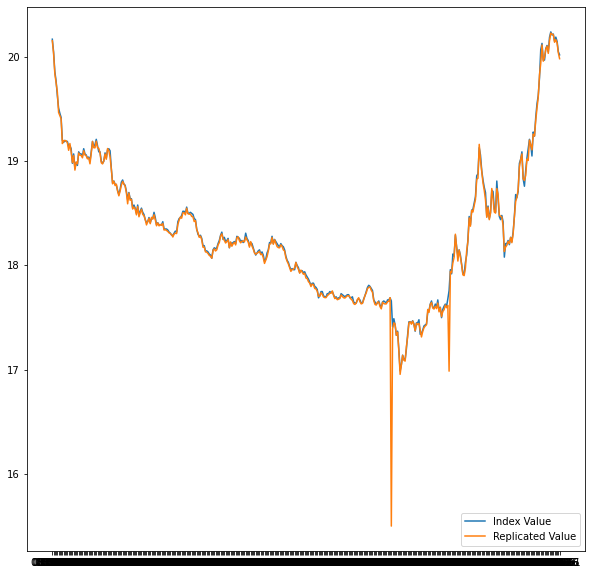

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
x = vix_value_minute_data['TIME_STAMP']
y1 = vix_value_minute_data['INDEX_VALUE']
y2 = vix_value_minute_data['Replicated Value']

plt.plot(x,y1,label='Index Value')
plt.plot(x,y2,label='Replicated Value')
plt.legend(loc='lower right')
plt.show()

## Subset Selection Approach 1

In [95]:
# Set the number of nearest options that are going to be selected
option_num = 50

# Step 2: Split the dataset according to the quotetime
subset_VIX_list = []

data_first_expire = data_two_dates[data_two_dates.expiration == expire_dates[0]]
data_second_expire = data_two_dates[data_two_dates.expiration == expire_dates[1]]

for quote_time in quote_time_list:
    
    # Step 3: Split the dataset into a near_term dataset and a next_term dataset
    near_term = data_first_expire[data_first_expire.quote_datetime == quote_time]
    next_term = data_second_expire[data_second_expire.quote_datetime == quote_time]
    
    # Step 4: Calculate the strike prices used in the calculation of F for both near_term and next_term options
    near_term_strike, pivoted_near_term = get_strike_price(near_term)
    next_term_strike, pivoted_next_term = get_strike_price(next_term)
    
    # Step 5: Calculate T, time to expiration, for both near_term and next_term options
    quote_time_dt = pd.to_datetime(quote_time)
    T1 = get_T(quote_time_dt.hour, quote_time_dt.minute, datetime.datetime(quote_time_dt.year, 
               quote_time_dt.month, quote_time_dt.day), expire_dates[0], near_term.root.iloc[0])
    T2 = get_T(quote_time_dt.hour, quote_time_dt.minute, datetime.datetime(quote_time_dt.year, 
                quote_time_dt.month, quote_time_dt.day), expire_dates[1], next_term.root.iloc[0])
    
    # Step 6: Calculate F, forward index price, for both near_term and next_term options
    # The R values are the 1-Month Daily Treasury Yield Curve Rates acquired from treasury.gov
    R1 = 0.0139
    R2 = 0.0139
    F1 = get_F(near_term_strike, R1, T1, pivoted_near_term)
    F2 = get_F(next_term_strike, R2, T2, pivoted_next_term)
    
    # Step 7: Calculate K0, the strike price equal to or immediately below F, for both near_term and next_term options
    K1 = get_K0(near_term, F1)
    K2 = get_K0(next_term, F2)

    # Step 8: Select the 50 nearest near-term put and call options
    near_term_nearest_p = near_term_p.iloc[-option_num:]
    near_term_nearest_c = near_term_c.iloc[:option_num]
    near_term_nearest_all = all_option_selection(near_term_nearest_p, near_term_nearest_c, near_term_atm)

    # Step 9: Select the 50 nearest next-term put and call options
    next_term_nearest_p = next_term_p.iloc[-option_num:]
    next_term_nearest_c = next_term_c.iloc[:option_num]
    next_term_nearest_all = all_option_selection(next_term_nearest_p, next_term_nearest_c, next_term_atm)

    # Step 10: Calculate the subset volatility
    subset_volatility1 = get_volatility(near_term_nearest_all, R1, T1, F1, K1)
    subset_volatility2 = get_volatility(next_term_nearest_all, R2, T2, F2, K2)
    
    # Step 11: Caluculate the VIX index value
    subset_VIX = get_VIX(T1, T2, subset_volatility1, subset_volatility2)
    subset_VIX_list.append(subset_VIX)

In [96]:
# Step 12: Read the VIX value data and compare
vix_value_data = pd.read_csv('^VIX_SPOT_20180221.csv')
vix_value_minute_data = vix_value_data.iloc[1440::4]
vix_value_minute_data = vix_value_minute_data.append(vix_value_data.iloc[-1])
vix_value_minute_data['Replicated Value'] = subset_VIX_list
vix_value_minute_data['Abs Difference'] = abs(vix_value_minute_data['INDEX_VALUE']-vix_value_minute_data['Replicated Value'])
print('MSE:', mean_squared_error(vix_value_minute_data['INDEX_VALUE'], vix_value_minute_data['Replicated Value']))
vix_value_minute_data

MSE: 2.5320352512982702


,TRADE_DT,TIME_STAMP,INDEX,INDEX_VALUE,Replicated Value,Abs Difference
1440,02/21/18,08:31:06,VIX,20.17,16.859923,3.310077
1444,02/21/18,08:32:06,VIX,20.05,16.869501,3.180499
1448,02/21/18,08:33:06,VIX,19.86,16.862125,2.997875
1452,02/21/18,08:34:06,VIX,19.77,16.860196,2.909804
1456,02/21/18,08:35:06,VIX,19.63,16.861209,2.768791
...,...,...,...,...,...,...
3040,02/21/18,15:11:06,VIX,20.15,16.929905,3.220095
3044,02/21/18,15:12:06,VIX,20.19,16.930625,3.259375
3048,02/21/18,15:13:06,VIX,20.15,16.929213,3.220787
3052,02/21/18,15:14:06,VIX,20.05,16.925501,3.124499


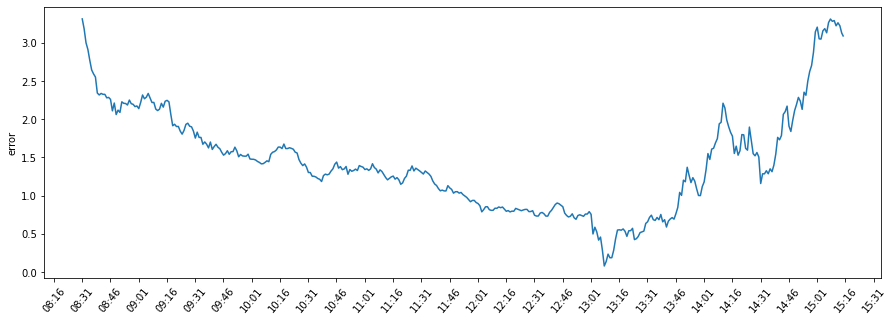

In [97]:
vix_value_minute_data['error'] = vix_value_minute_data['INDEX_VALUE'] - vix_value_minute_data['Replicated Value']
vix_value_minute_data = vix_value_minute_data.reset_index()
vix_value_minute_data.loc[vix_value_minute_data['error']>0.4]

x_time = [datetime.datetime.strptime(d,"%H:%M:%S") for d in vix_value_minute_data["TIME_STAMP"]]
formatter = DateFormatter("%H:%M")
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(x_time,vix_value_minute_data['error'])
ax.set_xticks(x_time)
plt.xticks(rotation = 50)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(MinuteLocator(interval=15))
plt.ylabel('error')
plt.show()

## Subset Selection Approach 2

In [98]:
# Set the number of nearest options that are going to be selected
option_num = 50

# Step 2: Split the dataset according to the quotetime
subset_VIX_list = []
near_term_list = []
next_term_list = []

data_first_expire = data_two_dates[data_two_dates.expiration == expire_dates[0]]
data_second_expire = data_two_dates[data_two_dates.expiration == expire_dates[1]]

for q in range(len(quote_time_list)):
    
    quote_time = quote_time_list[q]
    
    # Step 3: Split the dataset into a near_term dataset and a next_term dataset
    near_term = data_first_expire[data_first_expire.quote_datetime == quote_time]
    next_term = data_second_expire[data_second_expire.quote_datetime == quote_time]
    near_term_dict = near_term.to_dict('index')
    next_term_dict = next_term.to_dict('index')

    # Step 4: Calculate the strike prices used in the calculation of F for both near_term and next_term options
    near_term_strike, pivoted_near_term = get_strike_price(near_term)
    next_term_strike, pivoted_next_term = get_strike_price(next_term)

    # Step 5: Calculate T, time to expiration, for both near_term and next_term options
    quote_time_dt = pd.to_datetime(quote_time)
    T1 = get_T(quote_time_dt.hour, quote_time_dt.minute, datetime.datetime(quote_time_dt.year, 
               quote_time_dt.month, quote_time_dt.day), expire_dates[0], near_term.root.iloc[0])
    T2 = get_T(quote_time_dt.hour, quote_time_dt.minute, datetime.datetime(quote_time_dt.year, 
                quote_time_dt.month, quote_time_dt.day), expire_dates[1], next_term.root.iloc[0])

    # Step 6: Calculate F, forward index price, for both near_term and next_term options
    # The R values are the 1-Month Daily Treasury Yield Curve Rates acquired from treasury.gov
    R1 = 0.0139
    R2 = 0.0139
    F1 = get_F(near_term_strike, R1, T1, pivoted_near_term)
    F2 = get_F(next_term_strike, R2, T2, pivoted_next_term)

    # Step 7: Calculate K0, the strike price equal to or immediately below F, for both near_term and next_term options
    K1 = get_K0(near_term, F1)
    K2 = get_K0(next_term, F2)

    # Step 8: Select the 50 nearest near-term put and call options at the beginning of the day and use them for the whole day
    if q == 0:
        near_term_nearest_p = near_term_p.iloc[-option_num:]
        near_term_nearest_c = near_term_c.iloc[:option_num]
        near_term_nearest_all = all_option_selection(near_term_nearest_p, near_term_nearest_c, near_term_atm)
        for index, row in near_term_nearest_all.iterrows():
            near_term_list.append((row['strike'], row['option_type']))
    else:
        nearest_all = []
        for option in near_term_list:
            for key, value in near_term_dict.items():
                if value['strike'] == option[0] and value['option_type'] == option[1]:
                    nearest_all.append(value)
        near_term_nearest_all = pd.DataFrame(nearest_all)
        near_term_nearest_all = near_term_nearest_all[['strike', 'option_type', 'Average Price']]
        near_term_nearest_all = near_term_nearest_all.sort_values(by=['strike'])
        
    # Step 9: Select the 50 nearest next-term put and call options at the beginning of the day and use them for the whole day
    if q == 0:
        next_term_nearest_p = next_term_p.iloc[-option_num:]
        next_term_nearest_c = next_term_c.iloc[:option_num]
        next_term_nearest_all = all_option_selection(next_term_nearest_p, next_term_nearest_c, next_term_atm)
        for index, row in next_term_nearest_all.iterrows():
            next_term_list.append((row['strike'], row['option_type']))
    else:
        nearest_all = []
        for option in next_term_list:
            for key, value in next_term_dict.items():
                if value['strike'] == option[0] and value['option_type'] == option[1]:
                    nearest_all.append(value)
        next_term_nearest_all = pd.DataFrame(nearest_all)
        next_term_nearest_all = next_term_nearest_all[['strike', 'option_type', 'Average Price']]
        next_term_nearest_all = next_term_nearest_all.sort_values(by=['strike'])

    # Step 10: Calculate the subset volatility
    subset_volatility1 = get_volatility(near_term_nearest_all, R1, T1, F1, K1)
    subset_volatility2 = get_volatility(next_term_nearest_all, R2, T2, F2, K2)
    
    # Step 11: Caluculate the VIX index value
    subset_VIX = get_VIX(T1, T2, subset_volatility1, subset_volatility2)
    subset_VIX_list.append(subset_VIX)

In [99]:
# Step 12: Read the VIX value data and compare
vix_value_data = pd.read_csv('^VIX_SPOT_20180221.csv')
vix_value_minute_data = vix_value_data.iloc[1440::4]
vix_value_minute_data = vix_value_minute_data.append(vix_value_data.iloc[-1])
vix_value_minute_data['Replicated Value'] = subset_VIX_list
vix_value_minute_data['Abs Difference'] = abs(vix_value_minute_data['INDEX_VALUE']-vix_value_minute_data['Replicated Value'])
print('MSE:', mean_squared_error(vix_value_minute_data['INDEX_VALUE'], vix_value_minute_data['Replicated Value']))
vix_value_minute_data

MSE: 3.778092263473611


,TRADE_DT,TIME_STAMP,INDEX,INDEX_VALUE,Replicated Value,Abs Difference
1440,02/21/18,08:31:06,VIX,20.17,16.859923,3.310077
1444,02/21/18,08:32:06,VIX,20.05,17.210855,2.839145
1448,02/21/18,08:33:06,VIX,19.86,17.150507,2.709493
1452,02/21/18,08:34:06,VIX,19.77,17.099749,2.670251
1456,02/21/18,08:35:06,VIX,19.63,17.050450,2.579550
...,...,...,...,...,...,...
3040,02/21/18,15:11:06,VIX,20.15,17.043822,3.106178
3044,02/21/18,15:12:06,VIX,20.19,17.044866,3.145134
3048,02/21/18,15:13:06,VIX,20.15,17.017028,3.132972
3052,02/21/18,15:14:06,VIX,20.05,16.958440,3.091560


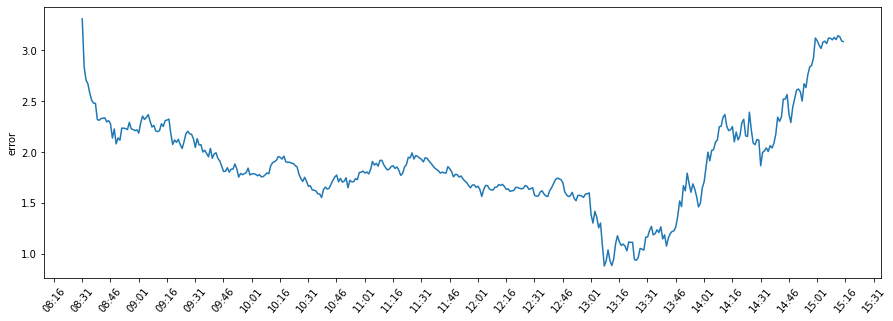

In [100]:
vix_value_minute_data['error'] = vix_value_minute_data['INDEX_VALUE'] - vix_value_minute_data['Replicated Value']
vix_value_minute_data = vix_value_minute_data.reset_index()
vix_value_minute_data.loc[vix_value_minute_data['error']>0.4]

x_time = [datetime.datetime.strptime(d,"%H:%M:%S") for d in vix_value_minute_data["TIME_STAMP"]]
formatter = DateFormatter("%H:%M")
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(x_time,vix_value_minute_data['error'])
ax.set_xticks(x_time)
plt.xticks(rotation = 50)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(MinuteLocator(interval=15))
plt.ylabel('error')
plt.show()